## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these. In this project I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [65]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [127]:
df=pd.read_csv('ab_data.csv')
df.head()
#reading in the dataset

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [67]:
len(df)#to find the number of rows

294478

c. The number of unique users in the dataset.

In [68]:
df.user_id.nunique() #to find the unique number of users

290584

d. The proportion of users converted.

In [69]:
df.converted[df.converted==1].count()/df.converted.count() #to find the proportion of user that converted


0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [70]:
df[(df.group == 'treatment') & (df.landing_page !='new_page')].count().sum()
# to find the number of times 

9825

f. Do any of the rows have missing values?

In [71]:
df.isnull().sum().sum() #to find any null(missing values)

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [72]:
df2=df[((df.group == 'treatment') & (df.landing_page =='new_page')) | ((df.group == 'control') & (df.landing_page =='old_page'))]
#to filter our new df so it only includes rows where treatment = new_page and control=old_page

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [73]:
df2.user_id.nunique() #to find the unique number of users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [74]:
df2[df2.user_id.duplicated()].user_id #to find the duplicate user ID
# if you want to find the row the duplicates are in run df2[df.user_id == 773192]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [129]:
df2[df2.user_id.duplicated()] 
#finds duplicated users

,user_id,timestamp,group,landing_page,converted,intercept,ab_page


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [130]:
df2=df2.drop_duplicates(['user_id'], keep='first') 
#dropping the second row where user_id was duplicated (keeping the first instance)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [131]:
conv=df2.converted[df2.converted==1].count()/df2.converted.count()
#returns the probability of a user converting
print(conv)


0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [132]:
contp=df2.query('group=="control"')['converted'].sum()/len(df2.query('group=="treatment"'))
#returns the probability of a user converting when an individual was in a control group
print(contp)
    

0.120356479251


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [133]:
treatp=df2.query('group=="treatment"')['converted'].sum()/len(df2.query('group=="treatment"'))
#returns the probability of a user converting when an individual was in the treatemnt group
print(treatp)

0.118808065515


d. What is the probability that an individual received the new page?

In [134]:
len(df2.query('landing_page=="new_page"'))/len(df2)  
#returns the probability of an individual receiving the new page

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Since the probabilities are close to each other it is not likely that one page will lead to more convertions.  The probablilty of an individual receiving a new page is practically one half, like the flip of a coin, meaning equal probability.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**H0:$p_{new}$ -$p_{old}$ < = 0 & H1:$p_{new} -$p_{old}$ > 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [81]:
pnew=df2['converted'].sum()/len(df2) #calculates the convert rate for p new under the null
#calculares the convert rate for pnew
print(pnew)


0.119597087245


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [82]:
pold=df2['converted'].sum()/len(df2) #calculates the convert rate for p old under the null
print(pold)

0.119597087245


c. What is $n_{new}$?

In [83]:
nnew=len(df2.query('landing_page=="new_page"')) #calculates n for new under the null
print(nnew)

145310


d. What is $n_{old}$?

In [84]:
nold=len(df2.query('landing_page=="old_page"')) #calculates the convert rate for n old under the null
print(nold)

145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [85]:
new_page_converted=np.random.choice(2, size=145310, p=[(1-pnew),(pnew)])
print(new_page_converted)

[0 0 0 ..., 0 0 0]


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [86]:
old_page_converted=np.random.choice(2, size=145274, p=[(1-pold),(pold)])  
#simulates n old transactions using p old 
print(old_page_converted)

[0 0 0 ..., 1 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [87]:
(new_page_converted.sum()/len(new_page_converted))-(old_page_converted.sum()/len(old_page_converted))


0.0005348334305043112

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [88]:
p_diffs=(np.random.binomial(nnew, pnew,10000)/nnew-np.random.binomial(nold,pold,10000))/nold
#we use a binomial distribition because values are discrete not continuous (1 or 0)
print(p_diffs)

[-0.11865771 -0.11914645 -0.11833417 ..., -0.11918775 -0.11841678
 -0.12056445]


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

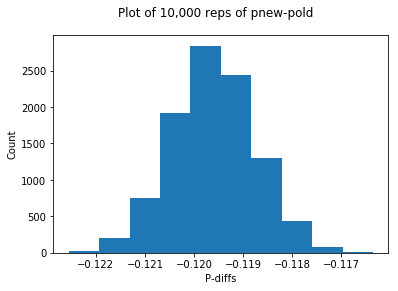

In [89]:
plt.hist(p_diffs)
plt.xlabel('P-diffs')
plt.ylabel('Count')
plt.suptitle("Plot of 10,000 reps of pnew-pold"); 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [90]:
actual_diffrence=(treatp)-(contp)
pddf=pd.DataFrame(p_diffs)
pddf.columns=['z']
len(pddf.query('z>@actual_diffrence'))/len(pddf)



0.0

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part J the  proportion of the p-diffs that were simulated were calculated and greater than the actual diffrence that was observed in the ab_data.csv. This is the critical value which is used to determined whether we should reject the null hyphtohesis.  If the test statistic is bigger than this critical value we can say there is statistical significance and the null hypotheis can be rejected.**





l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [91]:
import statsmodels.api as sm

convert_old = df2.query("landing_page=='old_page' and converted==1").shape[0]
convert_new = df2.query("landing_page=='new_page' and converted==1").shape[0]
n_old = nold
n_new = nnew


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [92]:
z_score, p_value=sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
print(z_score, p_value)

-1.31092419842 0.189883374482


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z score is |-1.3109| and the p value equals 0.18988.   The z score is smaller than the critical value so the null hyphothesis is NOT rejected.  This means that that old pages are converter more thand the new page users.  In J & K results there was no diffrence in conversion, so the results match.  ** 


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression since there are one or more independent variables that determine an outcome.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colunm for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [93]:
df2['intercept']=1 
df2[['ab_page','old_page']]=pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis=1)
df2.head()


#get_dummies creates a new DataFrame with binary variables

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [94]:
l=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=l.fit()

#Binary choice logit model

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [95]:
results.summary()
#returns a summary of the results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 30 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        00:12:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?



***The p value associated with ab_page is LLR p-value:0.1899.  Alpha=0.05, therefore p is greater than alpha so we fail to reject the null which states that the new page is less efficient or equaly as efficient as the old landing page. It differs from the value we found in part II because in part II we were testing if the convertsion rates varied. Where as here we are testing effectiveness of landing page. A regression measures the relation between mltiple variables, where as the z score was used single mean and used to t est a hypothesis on a specific value.  ***

f. Now, consider other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**A change in landing page can be cause by more than one factor. Certain people in a population might be more inclined to the change than others.   Using regression doesn't give you the complete picture, and when you add more terms in to the regression model you have to select independent terms.  Using non-independent variables in a regression model can can alter the results. Multicollinearity is when your variables are related, and this should be avoided. **

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  

In [135]:
country_df=pd.read_csv('countries.csv')
country_df.head()
#reading in file

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [136]:
df_x=country_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_x.head()
#merging datasets

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [137]:
df_x[['CA', 'UK', 'US']] = pd.get_dummies(df_x['country'])
df_x = df_x.drop('CA', axis = 1)
df_x.head()
#creating dummy variables for the country columns

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [141]:
logit = sm.Logit(df_x['converted'], df_x[['intercept','ab_page','UK', 'US']])
#to run regression results
results = logit.fit()
results.summary()
#to see regression results

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 30 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        02:45:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Does it appear that country had an impact on conversion?

**It does not appear that the country had an impact on conversion. The p-value:0.1760, still greater than Alpha=0.05, so we still fail to reject the null.**



h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  


In [143]:
logit = sm.Logit(df_x['converted'], df_x[['intercept', 'ab_page','UK', 'US']])
#to run regression results with given parameters
results = logit.fit()
results.summary()
#sumarizes regression results

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 30 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        02:52:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**It does not appear that the interaction between page and country had an impact on conversion. The p-value:0.1760, still greater than Alpha=0.05, so we still fail to reject the null. Further analysis would have to be done to find something that can has an impact conversion.**

<a id='conclusions'></a>







In [144]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0